# Analyse des différents championnats du monde d'échecs

Le but de ce projet est d'analyser les différents championnats du monde d'échecs et de comparer la qualité du niveau de jeu au fil du temps.

In [2]:
import chess
import chess.pgn
import itertools
from statistics import mean
import os
import csv
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


## Récupération et traitement des données

Chaque match de championnat du monde possède une study lichess sur ce __[lien](https://lichess.org/page/world-championships)__. On peut donc récuperer toutes les parties de tous les championnats du monde grâce à l'API de lichess. On récupère les clés de chaque study avec un peu de web scraping. 

Les parties ont été analysées sur lichess et les évaluations sont inscrites dans le pgn. La métrique utilisée pour évaluer une position est le centipion (100 centipions correspond à 1 pion). Pour chaque partie, on récupère les évaluations de chaque position ce qui nous permet d'obtenir un ACPL (average centipawn loss) pour chacun des 2 joueurs de la partie. En moyennant cet ACPL sur toutes les parties du match, on peut connaître le niveau global d'un match et ainsi le comparer aux autres matchs de championnat du monde.

In [2]:
from bs4 import BeautifulSoup
page = requests.get('https://lichess.org/page/world-championships')
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
lists = soup.find_all('li')
matches = lists[5:52]

def get_infos(string):
    s = string.find('y')
    key = string[s+2:s+10]
    t = string.find('>',10)
    u = string[t:].find('<')
    title = string[t+1:][:u-1].replace(' ','_')
    return key, title

key, title = get_infos(str(matches[-1]))
print(key)
print(title)
type(key)

7WCFYt0R
2018_Carlsen_vs._Caruana


str

In [61]:
path = "C:/Users/danih/OneDrive/Bureau/PYTHON/notebooks/PGN/"
for m in matches :
    key, title = get_infos(str(m))
    webpage = 'https://lichess.org/api/study/'+key + '.pgn'
    page = requests.get(webpage)
    if page.status_code == 429 :    #Trop de requêtes, on doit attendre 60 sec
        time.sleep(60)
        webpage = 'https://lichess.org/api/study/'+key + '.pgn'
        page = requests.get(webpage)
        file = open(path+title+'.pgn', "w") 
        file.write(page.text) 
        file.close()
    else:
        file = open(path+title+'.pgn', "w") 
        file.write(page.text) 
        file.close()

In [18]:
page = requests.get('https://lichess.org/api/study/BMFW3TsC.pgn')
file = open(path+'2021_Carlsen-Nepo.pgn', "w") 
file.write(page.text) 
file.close()

page = requests.get('https://lichess.org/api/study/y9K4s2ob.pgn')
file = open(path+'2023_Ding-Nepo.pgn', "w") 
file.write(page.text) 
file.close()

In [59]:
def pgnProcess(pgn, event):

    def pairwise(iterable):
        # pairwise('ABCDEFG') --> AB BC CD DE EF FG
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    output = []
    count = 0
    while True:

        game = chess.pgn.read_game(f)
        if not game:
            break

        count += 1

        w = game.headers['White']
        b = game.headers['Black']
        year = event.split('_')[0]
        evals = []

        if sum(1 for _ in game.mainline()) < 10:
            continue  # on skip les parties qui font moins de 10 ply (5 coups)

        for node in itertools.islice(game.mainline(), 200):  # l'analyse s'arrête au play 200 (coup 100)
            if node.board().is_game_over():
                continue  # no eval for mate played
            evals.append(max(min(node.eval().white(), chess.engine.Cp(1000)), chess.engine.Cp(-1000)).score())  

        evals[0] = 35  # on met l'évaluation de la position initiale à 35 centipions

        def difference(n, evals):
            a, b = evals
            if n % 2 != 0:
                return max((a - b), 0)
            return max((b - a), 0)

        cpls = []
        for n, pair in enumerate(pairwise(evals)):
            cpls.append(difference(n, pair))

        black_evals = cpls[::2]
        white_evals = cpls[1::2]
        output.append([event, year, count, w, mean(white_evals), len(white_evals), b, mean(black_evals), len(black_evals), mean(white_evals) + mean(black_evals)])
        print('!', event, len(output))
    return output


In [63]:
full_output = []
headers = ['Event', 'Year', 'Game Number', 'White Player', 'White ACPL', 'White Num Moves', 'Black Player', 'Black ACPL', 'Black Num Moves', 'Combined ACPL']


events = os.listdir(path)
for event in events:
    # print(event)
    with open(path + event) as f:
        event_outputs = pgnProcess(f, event)
    for output in event_outputs:
        full_output.append(output)

with open('analysis.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(full_output)


! 1886_Steinitz_vs._Zukertort.pgn 1
! 1886_Steinitz_vs._Zukertort.pgn 2
! 1886_Steinitz_vs._Zukertort.pgn 3
! 1886_Steinitz_vs._Zukertort.pgn 4
! 1886_Steinitz_vs._Zukertort.pgn 5
! 1886_Steinitz_vs._Zukertort.pgn 6
! 1886_Steinitz_vs._Zukertort.pgn 7
! 1886_Steinitz_vs._Zukertort.pgn 8
! 1886_Steinitz_vs._Zukertort.pgn 9
! 1886_Steinitz_vs._Zukertort.pgn 10
! 1886_Steinitz_vs._Zukertort.pgn 11
! 1886_Steinitz_vs._Zukertort.pgn 12
! 1886_Steinitz_vs._Zukertort.pgn 13
! 1886_Steinitz_vs._Zukertort.pgn 14
! 1886_Steinitz_vs._Zukertort.pgn 15
! 1886_Steinitz_vs._Zukertort.pgn 16
! 1886_Steinitz_vs._Zukertort.pgn 17
! 1886_Steinitz_vs._Zukertort.pgn 18
! 1886_Steinitz_vs._Zukertort.pgn 19
! 1886_Steinitz_vs._Zukertort.pgn 20
! 1889_Steinitz_vs._Chigorin.pgn 1
! 1889_Steinitz_vs._Chigorin.pgn 2
! 1889_Steinitz_vs._Chigorin.pgn 3
! 1889_Steinitz_vs._Chigorin.pgn 4
! 1889_Steinitz_vs._Chigorin.pgn 5
! 1889_Steinitz_vs._Chigorin.pgn 6
! 1889_Steinitz_vs._Chigorin.pgn 7
! 1889_Steinitz_vs._Chig

! 1929_Alekhine_vs._Bogoljubow.pgn 16
! 1929_Alekhine_vs._Bogoljubow.pgn 17
! 1929_Alekhine_vs._Bogoljubow.pgn 18
! 1929_Alekhine_vs._Bogoljubow.pgn 19
! 1929_Alekhine_vs._Bogoljubow.pgn 20
! 1929_Alekhine_vs._Bogoljubow.pgn 21
! 1929_Alekhine_vs._Bogoljubow.pgn 22
! 1929_Alekhine_vs._Bogoljubow.pgn 23
! 1929_Alekhine_vs._Bogoljubow.pgn 24
! 1929_Alekhine_vs._Bogoljubow.pgn 25
! 1934_Alekhine_vs_Bogoljubow_II.pgn 1
! 1934_Alekhine_vs_Bogoljubow_II.pgn 2
! 1934_Alekhine_vs_Bogoljubow_II.pgn 3
! 1934_Alekhine_vs_Bogoljubow_II.pgn 4
! 1934_Alekhine_vs_Bogoljubow_II.pgn 5
! 1934_Alekhine_vs_Bogoljubow_II.pgn 6
! 1934_Alekhine_vs_Bogoljubow_II.pgn 7
! 1934_Alekhine_vs_Bogoljubow_II.pgn 8
! 1934_Alekhine_vs_Bogoljubow_II.pgn 9
! 1934_Alekhine_vs_Bogoljubow_II.pgn 10
! 1934_Alekhine_vs_Bogoljubow_II.pgn 11
! 1934_Alekhine_vs_Bogoljubow_II.pgn 12
! 1934_Alekhine_vs_Bogoljubow_II.pgn 13
! 1934_Alekhine_vs_Bogoljubow_II.pgn 14
! 1934_Alekhine_vs_Bogoljubow_II.pgn 15
! 1934_Alekhine_vs_Bogoljubow

! 1958_Botvinnik_vs._Smyslov_III.pgn 8
! 1958_Botvinnik_vs._Smyslov_III.pgn 9
! 1958_Botvinnik_vs._Smyslov_III.pgn 10
! 1958_Botvinnik_vs._Smyslov_III.pgn 11
! 1958_Botvinnik_vs._Smyslov_III.pgn 12
! 1958_Botvinnik_vs._Smyslov_III.pgn 13
! 1958_Botvinnik_vs._Smyslov_III.pgn 14
! 1958_Botvinnik_vs._Smyslov_III.pgn 15
! 1958_Botvinnik_vs._Smyslov_III.pgn 16
! 1958_Botvinnik_vs._Smyslov_III.pgn 17
! 1958_Botvinnik_vs._Smyslov_III.pgn 18
! 1958_Botvinnik_vs._Smyslov_III.pgn 19
! 1958_Botvinnik_vs._Smyslov_III.pgn 20
! 1958_Botvinnik_vs._Smyslov_III.pgn 21
! 1958_Botvinnik_vs._Smyslov_III.pgn 22
! 1958_Botvinnik_vs._Smyslov_III.pgn 23
! 1960_Botvinnik_vs._Tal_.pgn 1
! 1960_Botvinnik_vs._Tal_.pgn 2
! 1960_Botvinnik_vs._Tal_.pgn 3
! 1960_Botvinnik_vs._Tal_.pgn 4
! 1960_Botvinnik_vs._Tal_.pgn 5
! 1960_Botvinnik_vs._Tal_.pgn 6
! 1960_Botvinnik_vs._Tal_.pgn 7
! 1960_Botvinnik_vs._Tal_.pgn 8
! 1960_Botvinnik_vs._Tal_.pgn 9
! 1960_Botvinnik_vs._Tal_.pgn 10
! 1960_Botvinnik_vs._Tal_.pgn 11
! 1960_B

! 1984_Karpov_vs._Kasparov.pgn 38
! 1984_Karpov_vs._Kasparov.pgn 39
! 1984_Karpov_vs._Kasparov.pgn 40
! 1984_Karpov_vs._Kasparov.pgn 41
! 1984_Karpov_vs._Kasparov.pgn 42
! 1984_Karpov_vs._Kasparov.pgn 43
! 1984_Karpov_vs._Kasparov.pgn 44
! 1984_Karpov_vs._Kasparov.pgn 45
! 1984_Karpov_vs._Kasparov.pgn 46
! 1984_Karpov_vs._Kasparov.pgn 47
! 1984_Karpov_vs._Kasparov.pgn 48
! 1985_Karpov_vs._Kasparov_II.pgn 1
! 1985_Karpov_vs._Kasparov_II.pgn 2
! 1985_Karpov_vs._Kasparov_II.pgn 3
! 1985_Karpov_vs._Kasparov_II.pgn 4
! 1985_Karpov_vs._Kasparov_II.pgn 5
! 1985_Karpov_vs._Kasparov_II.pgn 6
! 1985_Karpov_vs._Kasparov_II.pgn 7
! 1985_Karpov_vs._Kasparov_II.pgn 8
! 1985_Karpov_vs._Kasparov_II.pgn 9
! 1985_Karpov_vs._Kasparov_II.pgn 10
! 1985_Karpov_vs._Kasparov_II.pgn 11
! 1985_Karpov_vs._Kasparov_II.pgn 12
! 1985_Karpov_vs._Kasparov_II.pgn 13
! 1985_Karpov_vs._Kasparov_II.pgn 14
! 1985_Karpov_vs._Kasparov_II.pgn 15
! 1985_Karpov_vs._Kasparov_II.pgn 16
! 1985_Karpov_vs._Kasparov_II.pgn 17
! 1985

! 2007_World_Championship_Tournament.pgn 40
! 2007_World_Championship_Tournament.pgn 41
! 2007_World_Championship_Tournament.pgn 42
! 2007_World_Championship_Tournament.pgn 43
! 2007_World_Championship_Tournament.pgn 44
! 2007_World_Championship_Tournament.pgn 45
! 2007_World_Championship_Tournament.pgn 46
! 2007_World_Championship_Tournament.pgn 47
! 2007_World_Championship_Tournament.pgn 48
! 2007_World_Championship_Tournament.pgn 49
! 2007_World_Championship_Tournament.pgn 50
! 2007_World_Championship_Tournament.pgn 51
! 2007_World_Championship_Tournament.pgn 52
! 2007_World_Championship_Tournament.pgn 53
! 2007_World_Championship_Tournament.pgn 54
! 2007_World_Championship_Tournament.pgn 55
! 2007_World_Championship_Tournament.pgn 56
! 2008_Anand_vs._Kramnik.pgn 1
! 2008_Anand_vs._Kramnik.pgn 2
! 2008_Anand_vs._Kramnik.pgn 3
! 2008_Anand_vs._Kramnik.pgn 4
! 2008_Anand_vs._Kramnik.pgn 5
! 2008_Anand_vs._Kramnik.pgn 6
! 2008_Anand_vs._Kramnik.pgn 7
! 2008_Anand_vs._Kramnik.pgn 8
! 20

## Résultats

In [3]:
df = pd.read_csv('analysis.csv')


cols_to_get = [1, 2, 3, 6, 9]
pretty_df = df[df.columns[cols_to_get]]

In [6]:
df.head(10)

,Event,Year,Game Number,White Player,White ACPL,White Num Moves,Black Player,Black ACPL,Black Num Moves,Combined ACPL
0,1886_Steinitz_vs._Zukertort.pgn,1886,1,"Zukertort, Johannes Hermann",47.688889,45,"Steinitz, William",27.934783,46,75.623671
1,1886_Steinitz_vs._Zukertort.pgn,1886,2,"Steinitz, William",48.111111,45,"Zukertort, Johannes Hermann",28.413043,46,76.524155
2,1886_Steinitz_vs._Zukertort.pgn,1886,3,"Zukertort, Johannes Hermann",28.565217,46,"Steinitz, William",49.456522,46,78.021739
3,1886_Steinitz_vs._Zukertort.pgn,1886,4,"Steinitz, William",29.842105,38,"Zukertort, Johannes Hermann",9.564103,39,39.406208
4,1886_Steinitz_vs._Zukertort.pgn,1886,5,"Zukertort, Johannes Hermann",16.451613,31,"Steinitz, William",39.483871,31,55.935484
5,1886_Steinitz_vs._Zukertort.pgn,1886,6,"Steinitz, William",46.133333,60,"Zukertort, Johannes Hermann",62.783333,60,108.916667
6,1886_Steinitz_vs._Zukertort.pgn,1886,7,"Zukertort, Johannes Hermann",50.823529,34,"Steinitz, William",21.142857,35,71.966387
7,1886_Steinitz_vs._Zukertort.pgn,1886,8,"Steinitz, William",25.238095,21,"Zukertort, Johannes Hermann",22.523810,21,47.761905
8,1886_Steinitz_vs._Zukertort.pgn,1886,9,"Zukertort, Johannes Hermann",48.513514,37,"Steinitz, William",21.842105,38,70.355619
9,1886_Steinitz_vs._Zukertort.pgn,1886,10,"Steinitz, William",10.250000,20,"Zukertort, Johannes Hermann",8.047619,21,18.297619


In [7]:
pretty_df.sort_values('Combined ACPL',ascending=True)

,Year,Game Number,White Player,Black Player,Combined ACPL
1013,2021,3,"Nepomniachtchi, Ian","Carlsen, Magnus",4.650000
1017,2021,7,"Nepomniachtchi, Ian","Carlsen, Magnus",6.150000
1032,2023,11,"Nepomniachtchi, Ian","Liren, Ding",6.421053
609,1978,15,"Korchnoi, Viktor","Karpov, Anatoly",6.666667
758,1987,18,"Kasparov, Gary","Karpov, Anatoly",6.687179
...,...,...,...,...,...
52,1890,16,"Gunsberg, Isidor","Steinitz, William",135.450000
10,1886,11,"Zukertort, Johannes Hermann","Steinitz, William",153.589744
74,1892,19,"Chigorin, Mikhail","Steinitz, William",167.129032
34,1889,15,"Chigorin, Mikhail","Steinitz, William",211.977778


Les 2 parties les mieux jouées ont été jouées par Carlsen et Nepomniachtchi lors du championnat du monde 2021.
Les parties les moins bien jouées ont été jouées par Chigorin et Steinitz.

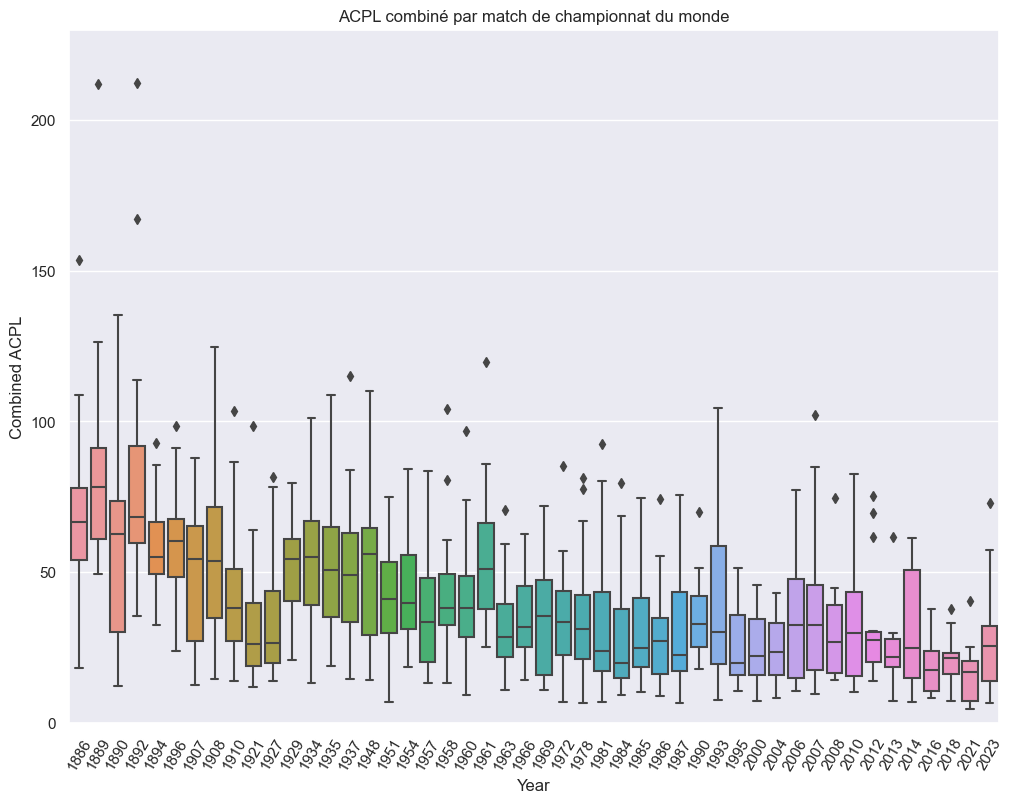

In [14]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(figsize=(12, 9))
axes.set_ylim(0, 230)
sns.boxplot(x='Year', y='Combined ACPL', data=df, ax=axes, dodge=False)
axes.set_title('ACPL combiné par match de championnat du monde')
axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plt.show()


On observe bien une tendance : plus on avance dans le temps, plus la qualité des parties augmente. Cela s'explique notamment par le fait qu'aujourd'hui les joueurs ont accès à la technologie et donc que tous les top joueurs s'entraînent avec l'ordinateur.

In [32]:
pretty_df.groupby("Year").mean()["Combined ACPL"].sort_values()

C:\Users\danih\AppData\Local\Temp\ipykernel_8964\439730713.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pretty_df.groupby("Year").mean()["Combined ACPL"].sort_values()


Year
2021    16.431851
2016    19.011944
2018    20.587622
2000    24.667786
2013    24.680065
2004    24.890089
1995    25.263600
1984    27.305744
2023    27.801896
1986    28.725220
2014    30.115247
2008    30.437647
1987    30.626686
2012    31.854030
1985    32.184945
1963    32.341867
1981    33.261497
2010    33.400536
1927    33.777138
2006    33.847077
1978    34.305351
1990    34.414745
1969    34.546567
1921    34.799122
2007    34.854190
1957    35.779251
1972    36.282051
1966    36.287092
1993    39.184984
1951    39.725294
1960    40.600874
1910    42.110058
1958    42.840428
1954    44.000995
1907    50.008820
1937    50.372693
1948    51.684097
1929    51.795669
1935    52.811221
1934    53.475792
1961    54.788916
1908    57.100244
1890    58.336588
1894    58.746449
1896    59.685453
1886    67.673932
1892    82.718162
1889    84.193393
Name: Combined ACPL, dtype: float64

Le championnat du monde de 2021 entre Carlsen et Nepomniachtchi est celui qui a produi la meilleure qualité de jeu, tandis que le championnat du monde de 1889 entre Steinitz et Chigorin et celui qui a produit la moins bonne qualité de jeu. A noter que le dernier championnat du monde, joué en 2023 par Nepomniachtchi et Liren se trouve en 9ème position.